In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import statsmodels.api as sm

price = pd.read_table('pricelist.csv',delimiter =';')
combi = pd.read_table('Historical_combi2.csv',delimiter =';')
I_2011 = pd.read_table('UralNWE_2011.csv',delimiter =';')

combi=combi.fillna(0)

In [29]:
I_2011

,Pred Year,Pred brent 2011,Pred FO 1% 2011,Pred FO 3.5% 2011,TD 2011,Actual 2011,MD 2011
0,2005,28.0,-5.70,-9.57,-2.21,-2.2,-2.59
1,2006,35.0,-5.74,-10.74,-2.23,-2.2,-3.32
2,2007,44.0,-8.58,-13.13,-2.70,-2.2,-3.94
3,2008,83.3,-13.55,-22.58,-4.21,-2.2,-4.83
4,2009,59.0,-9.26,-14.37,-3.17,-2.2,-3.58
5,2010,82.0,-7.32,-12.52,-2.98,-2.2,-3.40


In [30]:
import datetime
datetimes = [datetime.datetime.strptime(d, '%d.%m.%Y') for d in combi["Date"]]


df = pd.DataFrame(datetimes, columns=['date'])
df.loc[:, 'date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

combi = combi.assign(df=df['date'].values)
#print(combi)


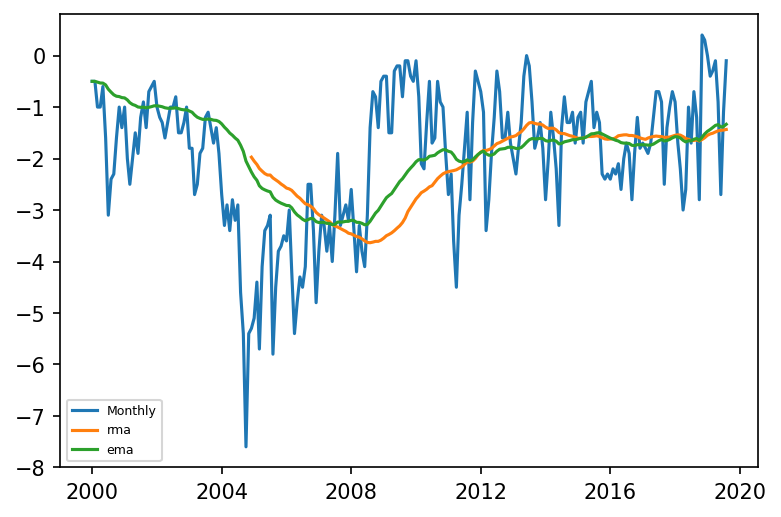

In [31]:
plt.rcParams['figure.dpi'] = 150

rma60 = combi["Urals NWE"].rolling(window=60).mean()
ema60 = combi["Urals NWE"].ewm(span=60, adjust=False).mean()
plt.plot(combi["df"],combi["Urals NWE"])
plt.plot(combi["df"],rma60)
plt.plot(combi["df"],ema60)
plt.legend(("Monthly","rma","ema"))
plt.show()

combi = combi.assign(ema60=ema60.values)
combi = combi.assign(rma60=rma60.values)

In [18]:
ema=[combi[combi['df']=='2005-01-01']['ema60'].values,combi[combi['df']=='2006-01-01']['ema60'].values   \
     ,combi[combi['df']=='2007-01-01']['ema60'].values,combi[combi['df']=='2008-01-01']['ema60'].values  \
     ,combi[combi['df']=='2009-01-01']['ema60'].values,combi[combi['df']=='2010-01-01']['ema60'].values]
ema

[array([-2.91153306]),
 array([-3.24332968]),
 array([-3.19924102]),
 array([-2.84018091]),
 array([-2.06205603]),
 array([-1.85929305])]

In [32]:
rma=[combi[combi['df']=='2005-01-01']['rma60'].values,combi[combi['df']=='2006-01-01']['rma60'].values   \
     ,combi[combi['df']=='2007-01-01']['rma60'].values,combi[combi['df']=='2008-01-01']['rma60'].values  \
     ,combi[combi['df']=='2009-01-01']['rma60'].values,combi[combi['df']=='2010-01-01']['rma60'].values]
rma

[array([-2.05]),
 array([-2.57333333]),
 array([-3.09166667]),
 array([-3.46333333]),
 array([-3.54666667]),
 array([-2.78333333])]

In [34]:
X = combi[['Dated Brent','FO 3.5%','FO 1%']]
Y = combi['Urals NWE']
regr = linear_model.LinearRegression()
regr.fit(X, Y)
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

DB= I_2011["Pred brent 2011"]
FO35= I_2011["Pred FO 3.5% 2011"]
FO1= I_2011["Pred FO 1% 2011"]
linear_UralN=regr.intercept_+ regr.coef_[0]*DB + regr.coef_[1]*FO35 + regr.coef_[2]*FO1
print(linear_UralN)

Intercept: 
 -0.8429775204230983
Coefficients: 
 [0.02021333 0.18105933 0.01406399]
                            OLS Regression Results                            
Dep. Variable:              Urals NWE   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     115.0
Date:                Tue, 24 Sep 2019   Prob (F-statistic):           1.21e-45
Time:                        15:09:38   Log-Likelihood:                -296.94
No. Observations:                 236   AIC:                             601.9
Df Residuals:                     232   BIC:                             615.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [35]:
nonlinear_UralN = 0.243310947652501*(FO35) + 0.0327070285007665*(DB) + 0.000931100809264595*np.power(FO1,3) + 3.01672677408283e-5*np.power(FO1,4) - 0.771156577782479 - 0.00241982760220774*(DB)*(FO1) - 0.000191940652210639*np.power(DB,2)

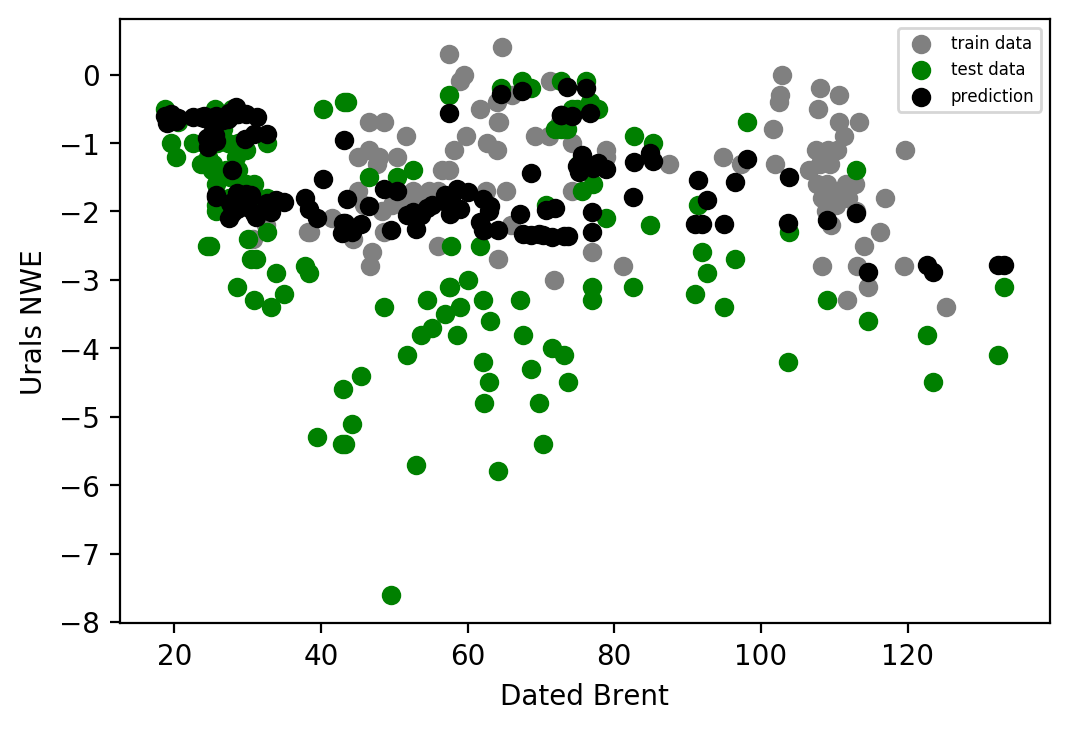

Mean squared error: 0.19
Feature ranking:
Feature Dated Brent (0.314084)
Feature FO 3.5% (0.520395)
Feature FO 1% (0.165521)


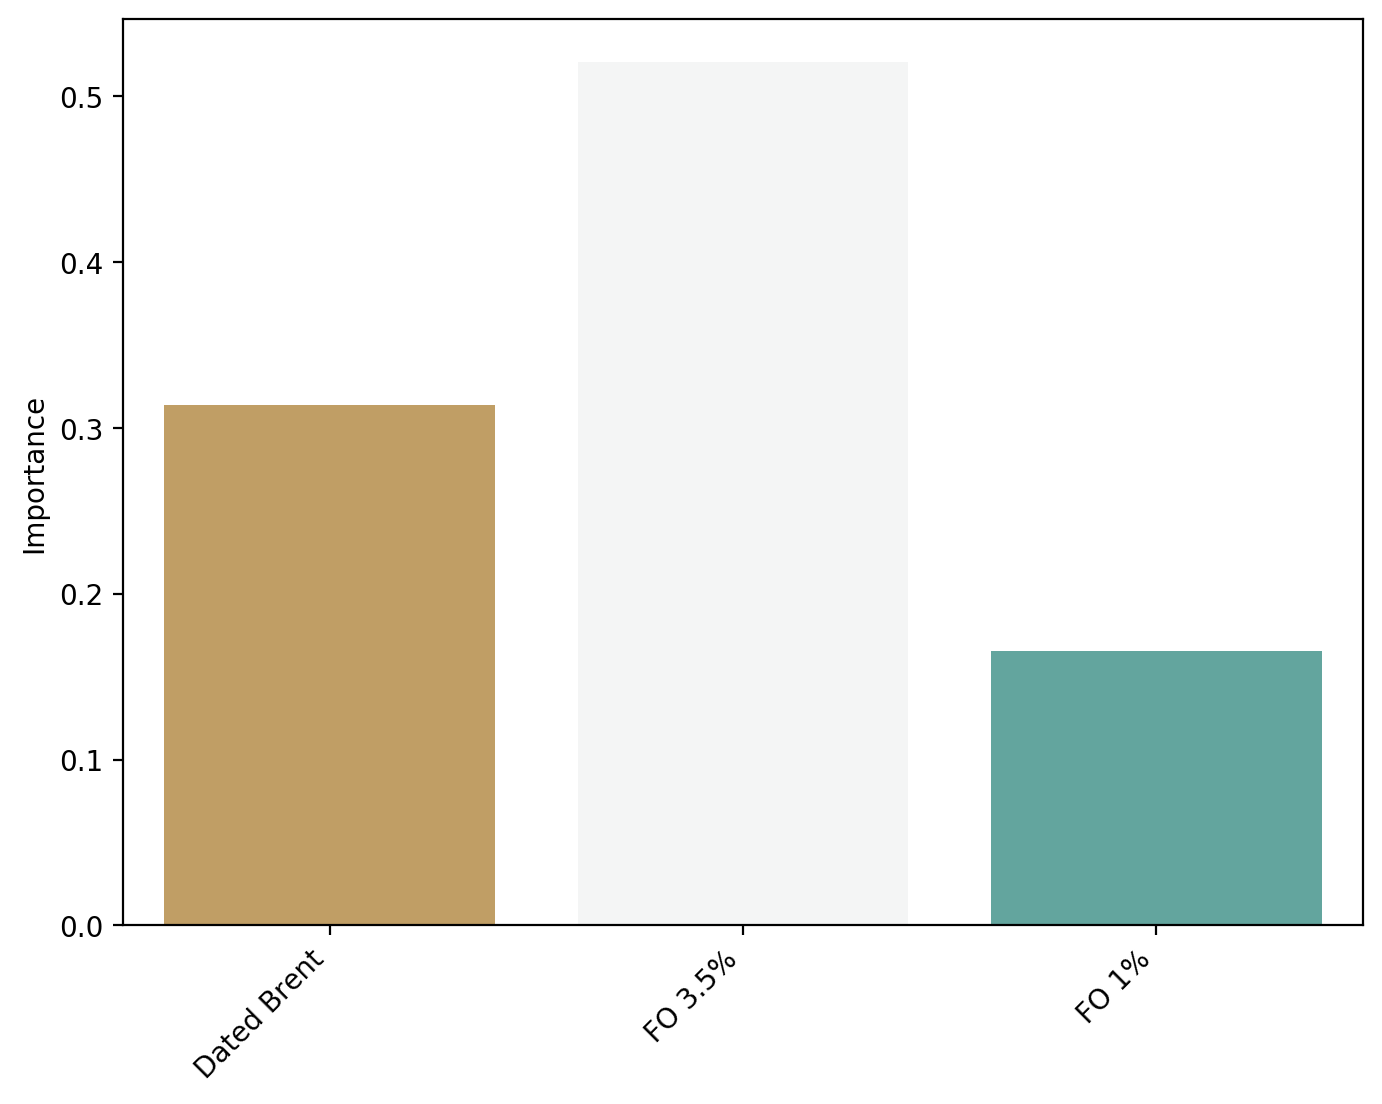

In [36]:
train_combi = combi.iloc[-100:,1:]
test_combi = combi.iloc[:-100,1:]

plt.rcParams['figure.dpi'] = 200

#x_train=train_combi.drop("Maya Europe",axis=1)
#x_train=train_combi[train_combi.columns.difference(["Mars"])]
x_train=train_combi[["Dated Brent","FO 3.5%", "FO 1%"]]
y_train=train_combi["Urals NWE"]

#df.drop('b', axis=1)

#x_test=train_combi.drop("Maya Europe",axis=1)
#x_test=test_combi[test_combi.columns.difference(["Mars"])]
x_test=test_combi[["Dated Brent","FO 3.5%", "FO 1%"]]
y_test=test_combi["Urals NWE"].to_frame()



regressor = RandomForestRegressor(n_estimators=200, max_depth=5)

clf=regressor.fit(x_train, y_train)

y_pred=regressor.predict(x_test)
y_pred=pd.DataFrame(y_pred)


plt_train=plt.scatter(x_train["Dated Brent"],y_train,   color='grey')
plt_test=plt.scatter(x_test["Dated Brent"],y_test,   color='green')
plt_pred=plt.scatter(x_test["Dated Brent"], y_pred,  color='black')



plt.xlabel("Dated Brent")
plt.ylabel("Urals NWE")
plt.legend((plt_train, plt_test,plt_pred),("train data", "test data","prediction"))
plt.show()

print("Mean squared error: %.2f"
      % np.mean((regressor.predict(x_train) - y_train) ** 2))

import seaborn as sns
importances=regressor.feature_importances_

indices=list(x_train)
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("Feature %s (%f)" % (indices[f], importances[f]))

f, (ax1) = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
sns.barplot(indices, importances, palette="BrBG", ax=ax1)
ax1.set_ylabel("Importance")

ax1.set_xticklabels(
    ax1.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);




In [38]:
#data_df = price[['Dated brent','FO 3.5%','FO 1%']]
data_df = pd.concat([DB, FO35,FO1],axis=1)
y_pred=regressor.predict(data_df)
y_pred= pd.DataFrame(y_pred)
print(y_pred)

          0
0 -2.102254
1 -1.899415
2 -1.718061
3 -2.280030
4 -1.535519
5 -1.287132


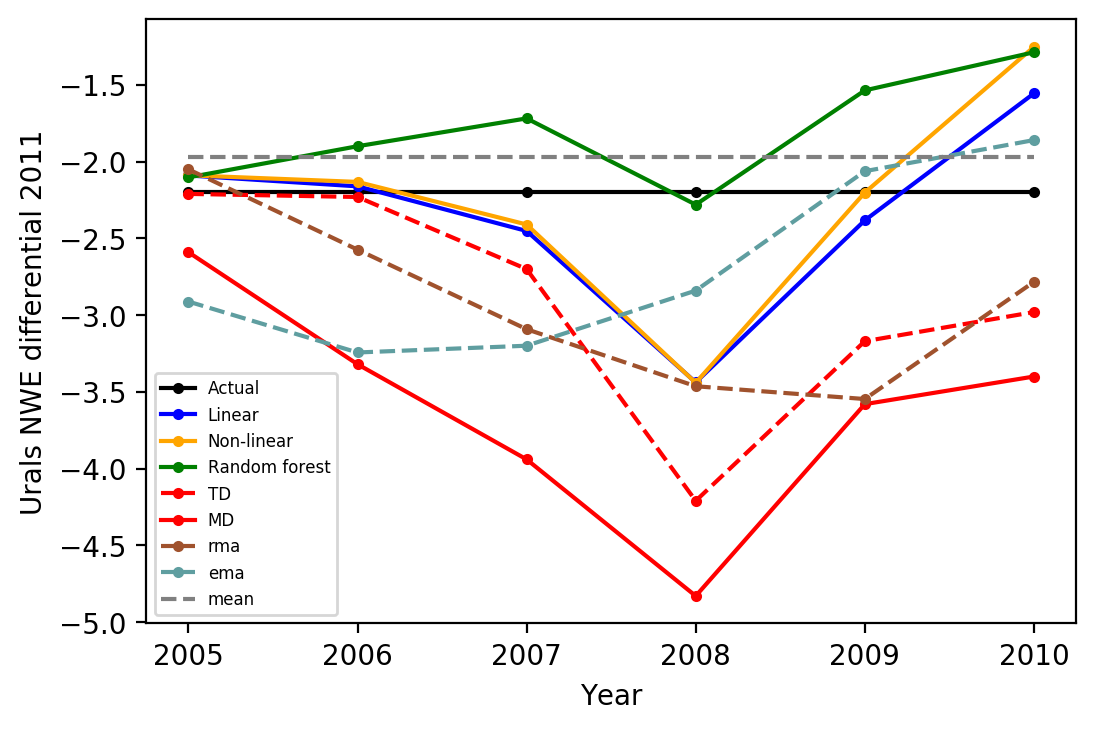

In [39]:
import pylab as plot
params = {'legend.fontsize': 6,
          'legend.handlelength': 2}
plot.rcParams.update(params)
plt.plot(I_2011["Pred Year"],I_2011["Actual 2011"],'k.-')
plt.plot(I_2011["Pred Year"],linear_UralN,'b.-')
plt.plot(I_2011["Pred Year"],nonlinear_UralN,'.-',color ='orange')
plt.plot(I_2011["Pred Year"],y_pred,'g.-')
plt.plot(I_2011["Pred Year"],I_2011["TD 2011"],'r.--')
plt.plot(I_2011["Pred Year"],I_2011["MD 2011"],'r.-')
plt.plot(I_2011["Pred Year"],rma,'.--',color ='sienna')
plt.plot(I_2011["Pred Year"],ema,'.--',color ='cadetblue')
plt.plot([I_2011["Pred Year"].iloc[0],I_2011["Pred Year"].iloc[-1]],[-1.97,-1.97],'--',color='grey')
plt.xlabel('Year')
plt.ylabel('Urals NWE differential 2011')
plt.legend(("Actual","Linear","Non-linear","Random forest","TD","MD","rma","ema","mean"))


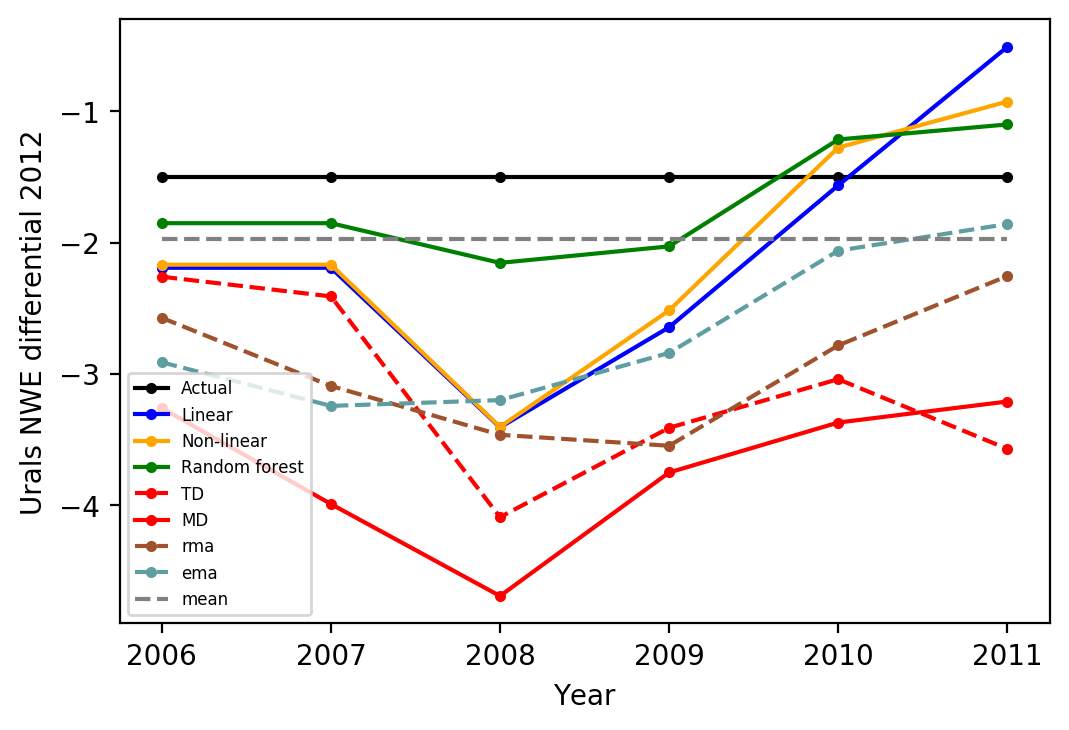

In [27]:
import pylab as plot
params = {'legend.fontsize': 6,
          'legend.handlelength': 2}
plot.rcParams.update(params)
plt.plot(I_2011["Pred Year"],I_2011["Actual 2012"],'k.-')
plt.plot(I_2011["Pred Year"],linear_UralN,'b.-')
plt.plot(I_2011["Pred Year"],nonlinear_UralN,'.-',color ='orange')
plt.plot(I_2011["Pred Year"],y_pred,'g.-')
plt.plot(I_2011["Pred Year"],I_2011["TD 2012"],'r.--')
plt.plot(I_2011["Pred Year"],I_2011["MD 2012"],'r.-')
plt.plot(I_2011["Pred Year"],rma,'.--',color ='sienna')
plt.plot(I_2011["Pred Year"],ema,'.--',color ='cadetblue')
plt.plot([I_2011["Pred Year"].iloc[0],I_2011["Pred Year"].iloc[-1]],[-1.97,-1.97],'--',color='grey')
plt.xlabel('Year')
plt.ylabel('Urals NWE differential 2012')
plt.legend(("Actual","Linear","Non-linear","Random forest","TD","MD","rma","ema","mean"))


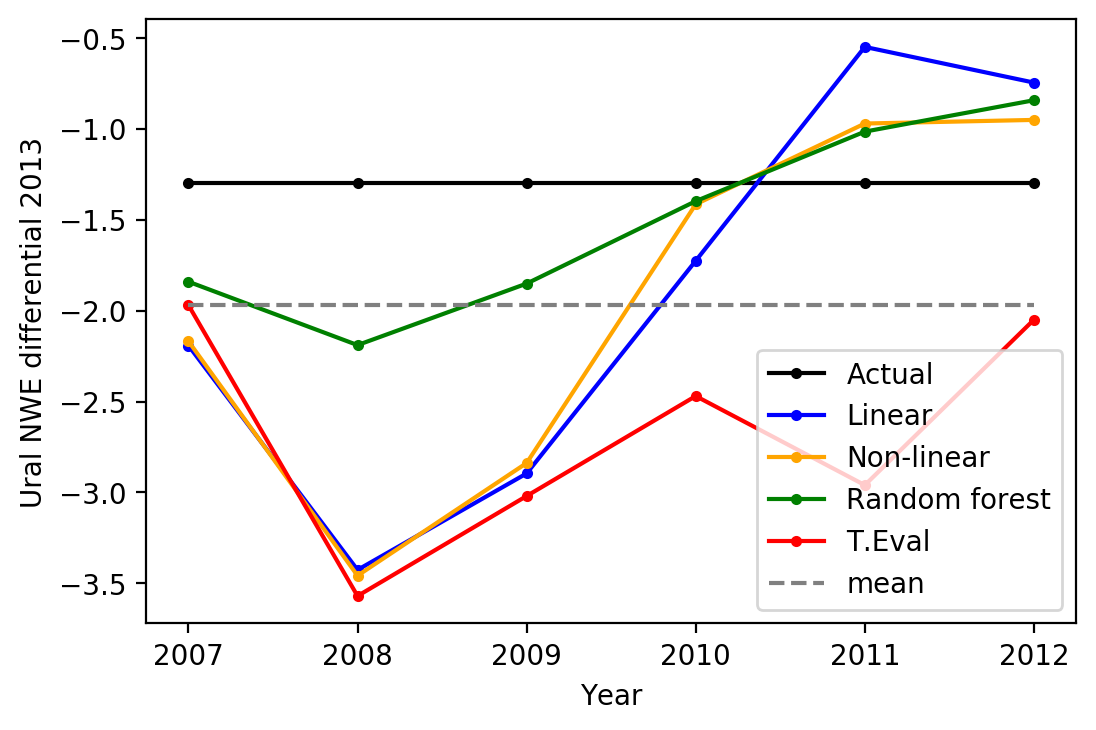

In [26]:
plt.plot(I_2011["Pred Year"],I_2011["Actual 2013"],'k.-')
plt.plot(I_2011["Pred Year"],linear_UralN,'b.-')
plt.plot(I_2011["Pred Year"],nonlinear_UralN,'.-',color ='orange')
plt.plot(I_2011["Pred Year"],y_pred,'g.-')
plt.plot(I_2011["Pred Year"],I_2011["TD 2013"],'r.-')
plt.plot([I_2011["Pred Year"].iloc[0],I_2011["Pred Year"].iloc[-1]],[-1.97,-1.97],'--',color='grey')
plt.xlabel('Year')
plt.ylabel('Ural NWE differential 2013')
plt.legend(("Actual","Linear","Non-linear","Random forest","T.Eval","mean"))

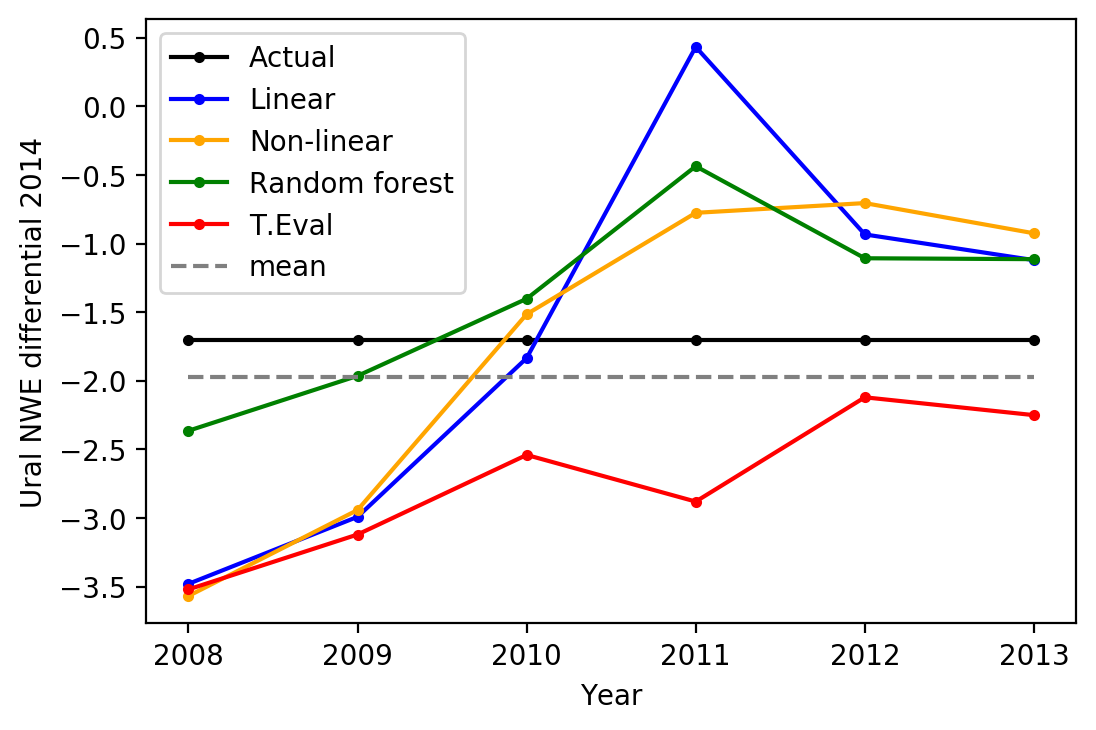

In [33]:
plt.plot(I_2011["Pred Year"],I_2011["Actual 2014"],'k.-')
plt.plot(I_2011["Pred Year"],linear_UralN,'b.-')
plt.plot(I_2011["Pred Year"],nonlinear_UralN,'.-',color ='orange')
plt.plot(I_2011["Pred Year"],y_pred,'g.-')
plt.plot(I_2011["Pred Year"],I_2011["TD 2014"],'r.-')
plt.plot([I_2011["Pred Year"].iloc[0],I_2011["Pred Year"].iloc[-1]],[-1.97,-1.97],'--',color='grey')
plt.xlabel('Year')
plt.ylabel('Ural NWE differential 2014')
plt.legend(("Actual","Linear","Non-linear","Random forest","T.Eval","mean"))

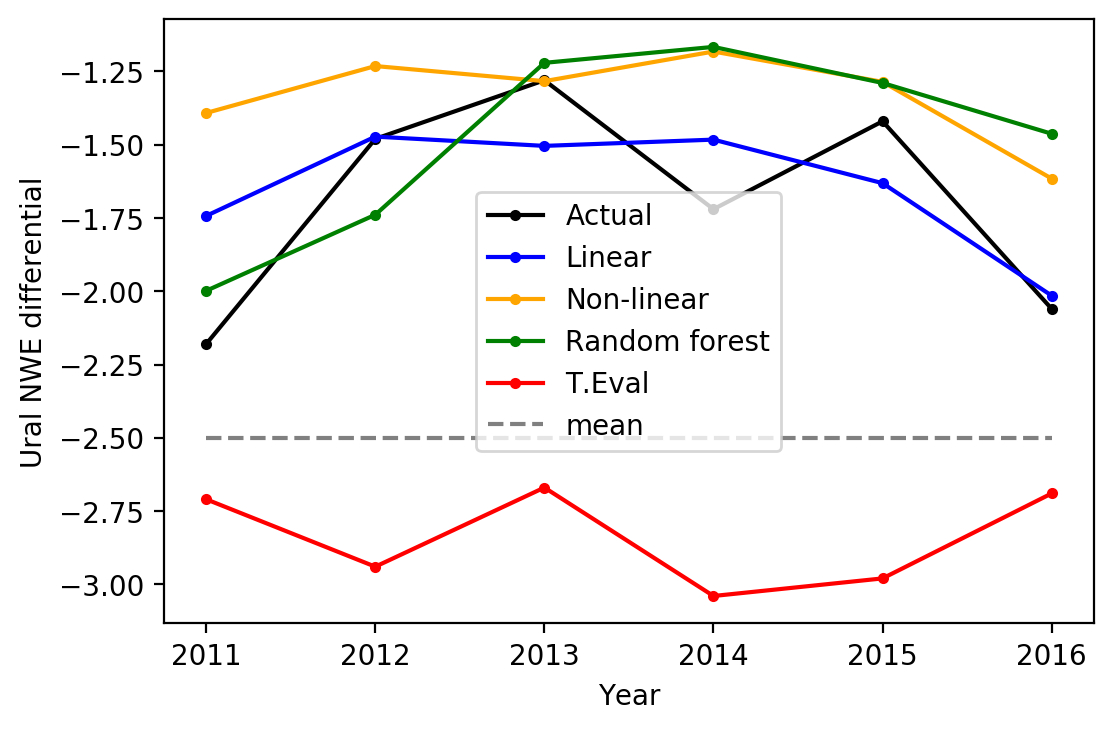

In [19]:
plt.plot(price["Year"],price["Actual UralNWE"],'k.-')
plt.plot(price["Year"],linear_UralN,'b.-')
plt.plot(price["Year"],nonlinear_UralN,'.-',color ='orange')
plt.plot(price["Year"],y_pred,'g.-')
plt.plot(price["Year"],price["TE UralNWE"],'r.-')
plt.plot([price["Year"].iloc[0],price["Year"].iloc[-1]],[-2.5,-2.5],'--',color='grey')
plt.xlabel('Year')
plt.ylabel('Ural NWE differential')
plt.legend(("Actual","Linear","Non-linear","Random forest","T.Eval","mean"))

In [16]:
price.drop(["Actual Dubai","TE Dubai","Actual WTI","TE WTI","Actual ESPO","TE ESPO","Actual MayaE","TE MayaE","Actual BL","TE BL"],axis=1)

,Year,Dated brent,Butane,VGO 0.5%,Jet Oil,Gasoil,FO 1%,FO 3.5%,pred Dubai,Actual UralNWE,TE UralNWE
0,2011,112,-29.0,3.47,16.92,13.98,-10.86,-16.83,-3.589,-2.18,-2.71
1,2012,110,-32.0,5.00,17.00,15.00,-4.00,-11.00,-2.475,-1.48,-2.94
2,2013,107,-32.4,4.90,19.70,17.10,-5.50,-12.10,-2.010,-1.28,-2.67
3,2014,108,-34.0,6.00,15.00,14.00,-9.00,-19.00,-2.910,-1.72,-3.04
4,2015,63,-29.0,1.00,19.00,16.00,-12.00,-16.00,-2.489,-1.42,-2.98
5,2016,65,-14.6,2.00,12.50,10.50,-10.50,-14.50,-2.350,-2.06,-2.69


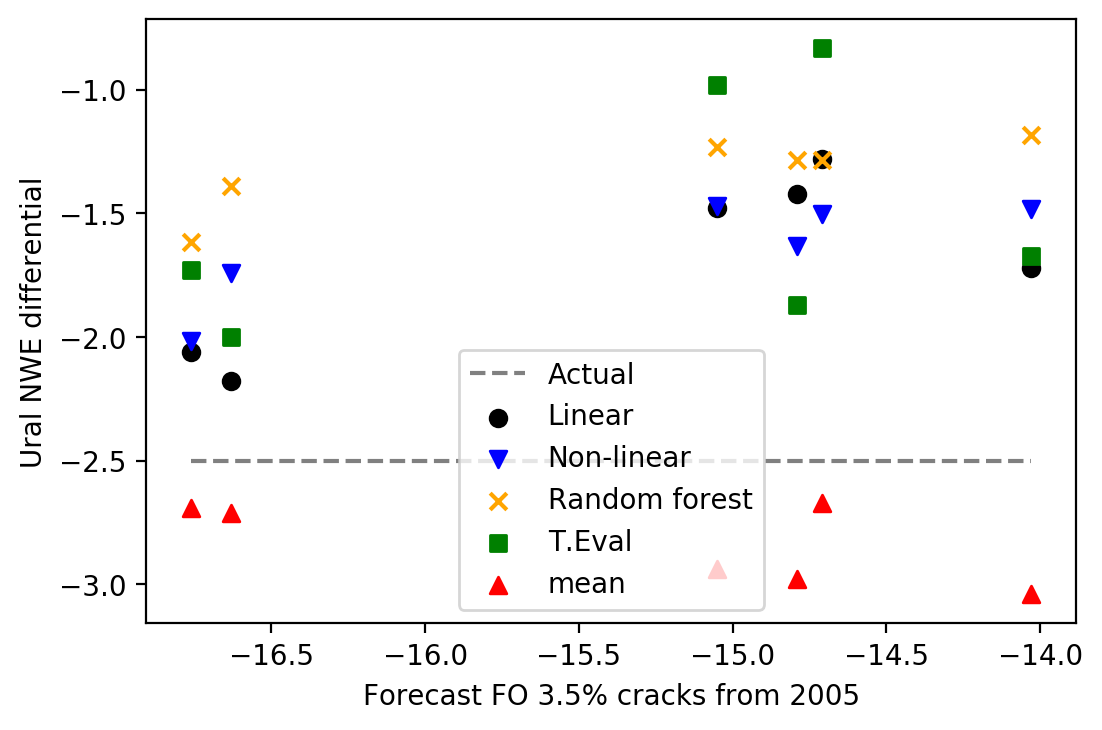

In [14]:
plt.scatter(price["FO 3.5% 2011 long"],price["Actual UralNWE"],color="black")
plt.scatter(price["FO 3.5% 2011 long"],linear_UralN,marker ="v",color="blue")
plt.scatter(price["FO 3.5% 2011 long"],nonlinear_UralN,marker ="x",color="orange")
plt.scatter(price["FO 3.5% 2011 long"],y_pred,marker ="s",color="green")
plt.scatter(price["FO 3.5% 2011 long"],price["TE UralNWE"],marker ="^",color="red")
plt.plot([price["FO 3.5% 2011 long"].min(),price["FO 3.5% 2011 long"].max()],[-2.5,-2.5],'--',color='grey')
plt.xlabel('Forecast FO 3.5% cracks from 2005')
plt.ylabel('Ural NWE differential')
plt.legend(("Actual","Linear","Non-linear","Random forest","T.Eval","mean"))

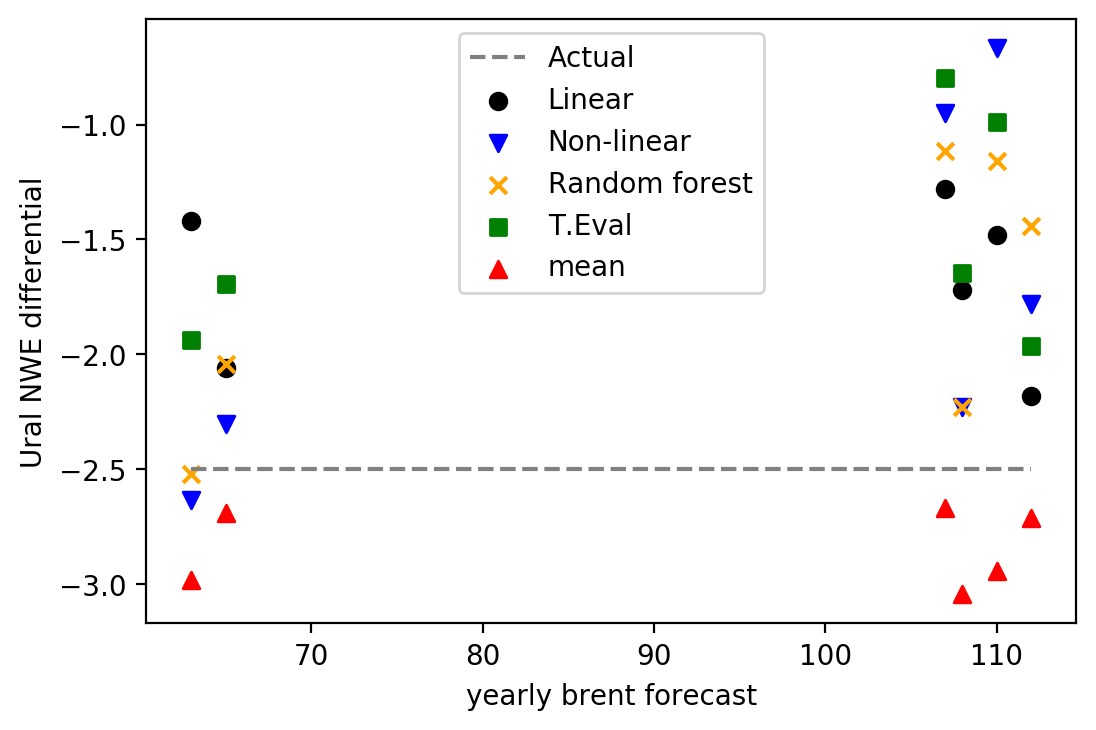

In [29]:
plt.scatter(price["Dated brent"],price["Actual UralNWE"],color="black")
plt.scatter(price["Dated brent"],linear_UralN,marker ="v",color="blue")
plt.scatter(price["Dated brent"],nonlinear_UralN,marker ="x",color="orange")
plt.scatter(price["Dated brent"],y_pred,marker ="s",color="green")
plt.scatter(price["Dated brent"],price["TE UralNWE"],marker ="^",color="red")
plt.plot([price["Dated brent"].min(),price["Dated brent"].max()],[-2.5,-2.5],'--',color='grey')
plt.xlabel('yearly brent forecast')
plt.ylabel('Ural NWE differential')
plt.legend(("Actual","Linear","Non-linear","Random forest","T.Eval","mean"))